In [54]:
from datetime import datetime
tickers_list = ['USDJPY=X', 'USDCHF=X', 'GC=F', 'EURUSD=X', 'BMW.DE']

download_path = './downloads'
start_time_for_gathering_data = '2011-01-01'
end_time_for_gathering_data = datetime.today().strftime('%Y-%m-%d')
interval_for_gathering_time = '1d'

In [55]:
import pandas as pd
import plotly.graph_objects as go
import yfinance as yf
from plotly.subplots import make_subplots
from utils.utility import path_exists, apply_total_signal, pointpos

import pandas_ta as ta

def fetch_data():
    ilist = []
    is_processed = False;
    for ticker in tickers_list:
        clean_ticker = ticker.replace('=X', '')
        clean_ticker = clean_ticker.replace('=F', '')
        file = path_exists(download_path, clean_ticker, '.csv')
        if file:
            ilist.append({clean_ticker: pd.read_csv(file)})
            is_processed = True

    if len(ilist) > 0:
        return ilist, is_processed

    df = yf.download(tickers=tickers_list, start=start_time_for_gathering_data, end=end_time_for_gathering_data,
                     interval=interval_for_gathering_time, group_by='ticker')

    df_usdjpy_candle_1d_2000_01_01_to_2024_08_04 = df[tickers_list[0]]
    df_usdchf_candle_1d_2000_01_01_to_2024_08_04 = df[tickers_list[1]]
    df_gold_candle_1d_2000_01_01_to_2024_08_04 = df[tickers_list[2]]
    df_eurusd_candle_1d_2000_01_01_to_2024_08_04 = df[tickers_list[3]]
    df_bmw_de_candle_1d_2000_01_01_to_2024_08_04 = df[tickers_list[4]]

    df_gold_candle_1d_2000_01_01_to_2024_08_04.to_csv(
        download_path + '/GC_candle_' + interval_for_gathering_time + start_time_for_gathering_data + '_TO_' + end_time_for_gathering_data + '.csv',
        mode='w+')

    df_usdchf_candle_1d_2000_01_01_to_2024_08_04.to_csv(
        download_path + '/USDCHF_candle_' + interval_for_gathering_time + start_time_for_gathering_data + '_TO_' + end_time_for_gathering_data + '.csv',
        mode='w+')

    df_eurusd_candle_1d_2000_01_01_to_2024_08_04.to_csv(
        download_path + '/EURUSD_candle_' + interval_for_gathering_time + start_time_for_gathering_data + '_TO_' + end_time_for_gathering_data + '.csv',
        mode='w+')

    df_usdjpy_candle_1d_2000_01_01_to_2024_08_04.to_csv(
        download_path + '/USDJPY_candle_' + interval_for_gathering_time + start_time_for_gathering_data + '_TO_' + end_time_for_gathering_data + '.csv',
        mode='w+')

    df_bmw_de_candle_1d_2000_01_01_to_2024_08_04.to_csv(
        download_path + '/BMW.DE_candle_' + interval_for_gathering_time + start_time_for_gathering_data + '_TO_' + end_time_for_gathering_data + '.csv',
        mode='w+')

    return [{'EURUSD': df_eurusd_candle_1d_2000_01_01_to_2024_08_04},
            {'GC': df_gold_candle_1d_2000_01_01_to_2024_08_04},
            {'USDCHF': df_usdchf_candle_1d_2000_01_01_to_2024_08_04},
            {'BMW.DE': df_bmw_de_candle_1d_2000_01_01_to_2024_08_04},
            {'USDJPY': df_usdjpy_candle_1d_2000_01_01_to_2024_08_04}], is_processed


def calc_primary_indicator(df):
    df = df[df.High != df.Low]

    df.ta.bbands(append=True, length=30, std=2)
    df.ta.rsi(append=True, length=14)
    df["atr"] = ta.atr(low=df.Low, close=df.Close, high=df.High, length=14)

    df.rename(columns={
        'BBL_30_2.0': 'bbl', 'BBM_30_2.0': 'bbm', 'BBU_30_2.0': 'bbh', 'RSI_14': 'rsi'
    }, inplace=True)

    # Calculate Bollinger Bands Width
    df['bb_width'] = (df['bbh'] - df['bbl']) / df['bbm']

    df.rename(
        columns={'bbl': 'BBL', 'bb_width': 'BB_WIDTH', 'bbm': 'BBM', 'bbh': 'BBH', 'rsi': 'RSI'},
        inplace=True)

    return df


def plot_chart_with_indicators(df, label, st):
    dfpl = df
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Candlestick(x=dfpl.Date,
                                 open=dfpl['Open'],
                                 high=dfpl['High'],
                                 low=dfpl['Low'],
                                 close=dfpl['Close']),
                  row=1, col=1)

    fig.add_trace(go.Scatter(x=dfpl.Date, y=dfpl['BBL'],
                             line=dict(color='blue', width=1),
                             name="BBL"),
                  row=1, col=1)
    fig.add_trace(go.Scatter(x=dfpl.Date, y=dfpl['BBH'],
                             line=dict(color='green', width=1),
                             name="BBU"),
                  row=1, col=1)

    # Add markers for trade entry points on the same subplot
    fig.add_trace(go.Scatter(x=dfpl.Date, y=dfpl['pointpos'], mode="markers",
                             marker=dict(size=8, color="MediumPurple"),
                             name="entry"),
                  row=1, col=1)

    fig.add_trace(go.Scatter(x=dfpl.Date, y=dfpl['RSI'],
                             line=dict(color='green', width=2),
                             name="RSI"),
                  row=2, col=1)

    fig.update_layout(width=1800, height=800, sliders=[], title_text=label)

    fig.show()

In [62]:
fetched_data_list, is_processed = fetch_data()
df_list = []
ticker_list = []
for item in fetched_data_list:
    df_list.append(pd.DataFrame(list(item.items())[0][1]))
    ticker_list.append(list(item.items())[0][0])

if not is_processed:
    for index in range(0, len(df_list)):
        df_list[index] = calc_primary_indicator(df_list[index])
        df_list[index] = df_list[index].round(4)
        df_list[index].reset_index(inplace=True)
        df_list[index].set_index('Date', inplace=True)
        df_list[index].to_csv(download_path + "/" + ticker_list[index] + '.csv')

total_signal_length = 0
final_df_list = []
for index in range(0, len(df_list)):
    df = df_list[index]
    df.ta.bbands(append=True, length=30, std=2)
    df.ta.rsi(append=True, length=14)
    df["atr"] = ta.atr(low=df.Low, close=df.Close, high=df.High, length=14)
    df.rename(columns={
        'BBL_30_2.0': 'bbl', 'BBM_30_2.0': 'bbm', 'BBU_30_2.0': 'bbh', 'RSI_14': 'rsi'
    }, inplace=True)

    # Calculate Bollinger Bands Width
    df['bb_width'] = (df['bbh'] - df['bbl']) / df['bbm']
    apply_total_signal(df=df, rsi_threshold_low=30, rsi_threshold_high=70, bb_width_threshold=0.001)
    df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)
    total_signal_length += len(df[df['TotalSignal'] != 0])
    final_df_list.append(df)
    print('Ticker : ' + ticker_list[index] + ' \n' )
    # print(df[df['TotalSignal'] != 0 ][['Date','Open', 'High', 'Low','Close', 'TotalSignal', 'pointpos']].head())

    plot_chart_with_indicators(df, ticker_list[index], st=500)

print("Total Signal Count Is: {}".format(total_signal_length))


Ticker : USDJPY 


Ticker : USDCHF 


Ticker : GC 


Ticker : EURUSD 


Ticker : BMW.DE 


Total Signal Count Is: 73


In [63]:
from backtesting import Strategy
from backtesting import Backtest

dfopt=  final_df_list[0]

dfopt = dfopt[dfopt['Open'].notna()]
# dfopt = df[0:10000]
def SIGNAL():
    return dfopt.TotalSignal

class MyStrat(Strategy):
    mysize = 0.1
    slcoef = 4
    TPcoef = 2

    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.atr[-1]
        tpatr = self.TPcoef*self.data.atr[-1]

        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + tpatr
            self.buy(sl=sl1, tp=tp1, size=self.mysize)

        if self.signal1==1 and len(self.trades)==0:
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - tpatr
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(dfopt, MyStrat, cash=10000, margin=1/10, commission=0.001) #0.0002
stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 16)],
                             TPcoef=[i/10 for i in range(10, 21)],
                             maximize='Return [%]', max_tries=300,
                             random_state=0,
                             return_heatmap=True)
stats

E:\Project\Farabi\StockMarketData\venv\Lib\site-packages\backtesting\backtesting.py:1054: FutureWarning:

Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead

C:\Users\S.Eyvazi\AppData\Local\Temp\ipykernel_21988\967085623.py:35: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Start                                     0.0
End                                    3543.0
Duration                               3543.0
Exposure Time [%]                    2.572075
Equity Final [$]                  9290.243032
Equity Peak [$]                       10000.0
Return [%]                           -7.09757
Buy & Hold Return [%]               79.460819
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -7.897003
Avg. Drawdown [%]                   -7.897003
Max. Drawdown Duration                 3244.0
Avg. Drawdown Duration                 3244.0
# Trades                                 21.0
Win Rate [%]                        19.047619
Best Trade [%]                       0.688992
Worst Trade [%]                      -2.23377
Avg. Trade [%]                    

In [79]:
idf = final_df_list[0]

idf['NextClose'] = idf['Close'].shift(-1) - idf['Close']

idf

Date     Open     High      Low    Close  Adj Close  Volume  BBL  \
0     2011-01-03   81.140   81.709   81.120   81.123     81.123     0.0  NaN   
1     2011-01-04   81.672   82.268   81.600   81.670     81.670     0.0  NaN   
2     2011-01-05   82.010   83.320   81.883   82.038     82.038     0.0  NaN   
3     2011-01-06   83.160   83.377   82.880   83.189     83.189     0.0  NaN   
4     2011-01-07   83.270   83.658   82.948   83.300     83.300     0.0  NaN   
...          ...      ...      ...      ...      ...        ...     ...  ...   
3539  2024-07-30  153.833  155.190  153.656  153.833    153.833     0.0  NaN   
3540  2024-07-31  152.670  153.581  149.664  152.670    152.670     0.0  NaN   
3541  2024-08-01  149.744  150.857  148.505  149.744    149.744     0.0  NaN   
3542  2024-08-02  149.201  149.764  146.424  149.201    149.201     0.0  NaN   
3543  2024-08-05  145.584  145.918  141.697  145.584    145.584     0.0  NaN   

      BBM  BBH  ...  BB_WIDTH  bbl  bbm  bbh        rsi  bb_width  \
0     NaN  NaN  ...       NaN  NaN  NaN  NaN        NaN       NaN   
1     NaN  NaN  ...       NaN  NaN  NaN  NaN        NaN       NaN   
2     NaN  NaN  ...       NaN  NaN  NaN  NaN        NaN       NaN   
3     NaN  NaN  ...       NaN  NaN  NaN  NaN        NaN       NaN   
4     NaN  NaN  ...       NaN  NaN  NaN  NaN        NaN       NaN   
...   ...  ...  ...       ...  ...  ...  ...        ...       ...   
3539  NaN  NaN  ...       NaN  NaN  NaN  NaN  32.469842       NaN   
3540  NaN  NaN  ...       NaN  NaN  NaN  NaN  28.711380       NaN   
3541  NaN  NaN  ...       NaN  NaN  NaN  NaN  21.856620       NaN   
3542  NaN  NaN  ...       NaN  NaN  NaN  NaN  20.861241       NaN   
3543  NaN  NaN  ...       NaN  NaN  NaN  NaN  15.724249       NaN   

      TotalSignal  pointpos  NextClose  Target  
0               0       NaN      0.547       2  
1               0       NaN      0.368       2  
2               0       NaN      1.151       2  
3               0       NaN      0.111       2  
4               0       NaN     -0.270       0  
...           ...       ...        ...     ...  
3539            0       NaN     -1.163       0  
3540            0       NaN     -2.926       0  
3541            0       NaN     -0.543       0  
3542            0       NaN     -3.617       0  
3543            0       NaN        NaN       0  

[3544 rows x 24 columns]

In [80]:
import numpy as np

conditions = [idf['NextClose'] < 0, idf['NextClose'] == 0, idf['NextClose'] > 0 ]
choices = [0, 1, 2]
idf['Target'] = np.select(conditions, choices)

In [81]:
idf[idf.Target == 1]

Date     Open     High      Low    Close  Adj Close  Volume  \
175   2011-09-05   76.892   76.962   76.680   76.902     76.902     0.0   
271   2012-01-17   76.810   76.870   76.569   76.820     76.820     0.0   
895   2014-06-09  102.512  102.590  102.360  102.480    102.480     0.0   
2714  2021-06-01  109.478  109.693  109.333  109.493    109.493     0.0   
3514  2024-06-25  159.686  159.750  159.253  159.686    159.686     0.0   

           BBL       BBM       BBH  ...  BB_WIDTH         bbl         bbm  \
175    75.9609   77.1988   78.4367  ...    0.0321   75.960921   77.198800   
271    76.4485   77.4853   78.5220  ...    0.0268   76.448525   77.485267   
895   101.2356  101.9962  102.7569  ...    0.0149  101.235598  101.996233   
2714  107.8941  108.9423  109.9905  ...    0.0192  107.894128  108.942333   
3514  154.5689  156.9405  159.3120  ...    0.0302  154.568926  156.940467   

             bbh        rsi  bb_width  TotalSignal  pointpos  NextClose  \
175    78.436679  44.223077  0.032070            0       NaN        0.0   
271    78.522009  39.251081  0.026760            0       NaN        0.0   
895   102.756869  57.484706  0.014915            0       NaN        0.0   
2714  109.990539  55.061151  0.019243            0       NaN        0.0   
3514  159.312008  69.629803  0.030222            0       NaN        0.0   

      Target  
175        1  
271        1  
895        1  
2714       1  
3514       1  

[5 rows x 24 columns]

Mean Squared Error Test : 1.547
Mean Squared Error Train : 0.040
Accuracy For Test : 0.612


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

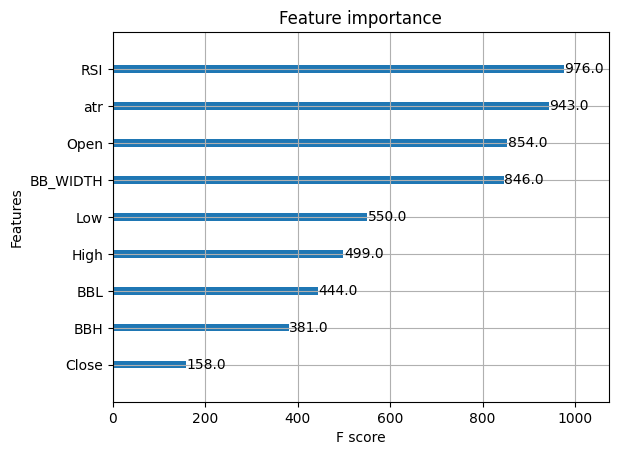

In [82]:
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
attribute = ['Open', 'High', 'Low','Close','Volume' , 'RSI', 'BBL', 'BBH', 'BB_WIDTH', 'atr' ]
target = idf['Target']
data = idf[attribute]
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.3)

# create model instance
bst = XGBClassifier()

# fit model
bst.fit(X_train, y_train)
# make predictions
y_pred = bst.predict(X_test)
predict_train = bst.predict(X_train)


mse=mean_squared_error(y_test, y_pred)
mse2=mean_squared_error(y_train, predict_train)

print('Mean Squared Error Test : {:.3f}'.format((mse)))
print('Mean Squared Error Train : {:.3f}'.format(mse2))

print('Accuracy For Test : {:.3f}'.format(accuracy_score(y_test, y_pred)))


plot_importance(bst)

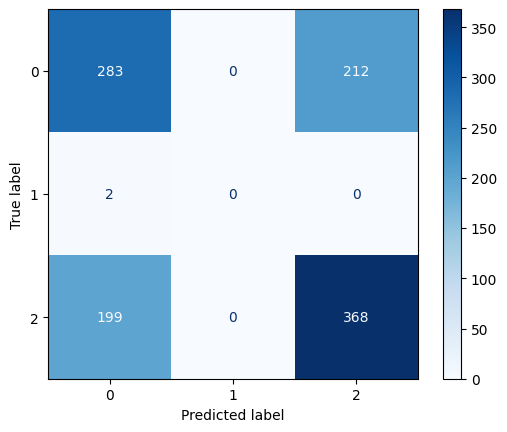

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bst.classes_)

disp.plot(cmap=plt.cm.Blues)

